# Profile forcing
To use the MAB reimplementation for our use case, we want to experiment with how we can force a certain population profile on the agents via a clever choice of parameters.

Lets say we have a simulation settings with $N$ agents, whose type is distributed according 
to $\Theta = (\theta_1, \theta_2)$, with negative externalities $L$. 
We inject an arm dependent win-chance (which can formally be included in the type distribution of the
agents as factor), so we have win-chance $Q(\theta, f)_i = \frac{\theta \cdot a_i}{1 + Lf}$ on arm $i$. 

We will now receive a stable population profile of the agents $f = (f_1, f_2)$. 
Let's say the arm-specific modifiers are coupled and sum to one, so $a_2 = 1 - a_1$. If $a_1 = 1$, we
expect $f \approx (1, 0)$, and if $a_1 = 0$ then $f \approx (0, 1)$. 

If we interpolate $a_1$ between $0$ and $1$, we would expect the resulting function to be monotonous, 
as doesn't make sense that increasing the win-chance on one arm decreases its total amount of players 
the equilibrium. We also expect the interpolation to be continous. By intermediate value theorem, 
the desired population profile $f'$ must be reachable through appropriate choice of $a_1$. Since $a_1$
must be monotonous, we know that $\| f' - f(a_1) \|^2_2$ has a global minimum, which can find by appropriate 
choice of optimization (Gradient Descent, Binary Search, ...), which a discussion of will follow.

We will first simulate the interpolation function of $a_1$ for a simple choice of $\Theta$.

What we imagine: For higher $L$ (strength of negative externalities), the exploration part of the agents will be larger, thus the extremes of $f$ will be further apart. The same holds for lower $\beta$, as the agents spend more time in exploration over all (as they are regenerated more frequently).

In [1]:
from simulations import Simulation
from utils import adjusted_two_arm_beta_type_sampler, negative_externality, ucb_strategy, adjusted_multi_arm_arm_beta_type_sampler
from optimization import simplex_projection, FixedStepGradientDescent
import pandas as pd
import altair as alt
import numpy as np
import matplotlib.pyplot as plt

In [2]:
steps = 200 
results = []
a1s = np.linspace(0, 1, 50)
Ls = [0.0, 0.2, 1.0, 10, 20] 
betas = [0.95, 0.98, 0.99]
rerun = False
csv_file = "results/profile_forcing_interpolation.csv"

if rerun:
    for run in range(1):
        for a1 in a1s:
            for L in Ls:
                for beta in betas:
                    sim = Simulation(2, 2000, adjusted_two_arm_beta_type_sampler(a1), negative_externality(L), beta=beta, strategy=ucb_strategy)
                    for _ in range(steps):
                        sim.step()
                    df = sim.get_history_df()
                    df = df[df.arm == 1]
                    results.append({"f1": df.profile[-20:].mean(), "a1": a1, "L": L, "beta": beta})
    interpolation_df = pd.DataFrame(results)
    interpolation_df.to_csv(csv_file)
else:
    interpolation_df = pd.read_csv(csv_file)

In [3]:
interpolation_df_averaged = interpolation_df.groupby(["a1", "L", "beta"]).mean().reset_index()
alt.Chart(interpolation_df_averaged[interpolation_df_averaged.beta == 0.98]).mark_line().encode(x="a1", y="f1", color="L:Q").interactive().display()
alt.Chart(interpolation_df_averaged[interpolation_df_averaged.L == 0.2]).mark_line().encode(x="a1", y="f1", color="beta:Q").interactive()

alt.Chart(...)

alt.Chart(...)

That worked pretty well. We will now take a short look at how the norm would look like:

In [4]:
f_prime = 0.6
interpolation_df_averaged["norm"] = (2 * (interpolation_df_averaged.f1 - f_prime) ** 2) ** (1/2)
alt.Chart(interpolation_df_averaged[interpolation_df_averaged.beta == 0.98]).mark_line().encode(x="a1", y="norm:Q", color="L:Q").interactive().display()
alt.Chart(interpolation_df_averaged[interpolation_df_averaged.L == 0.2]).mark_line().encode(x="a1", y="norm:Q", color="beta:Q").interactive()

alt.Chart(...)

alt.Chart(...)

Now assume that we want to find $f'$. Which algorithms might be used to get there?

A first idea is using projected gradient descent with a fixed step size, as we know that if $\theta_i$ increases,
so does $f_i$ (giving us an approximate gradient direction).

We will increase the problem size to more dimensions and try to see if GD helps:

In [5]:
f_prime = np.array([0.5, 0.2, 0.3], dtype=np.float64)

def f(theta_r: np.ndarray) -> np.ndarray:
    sim = Simulation(3, 500, adjusted_multi_arm_arm_beta_type_sampler(thetas=list(theta_r), betas=[(2,1), (1,1), (3,1)]), negative_externality(0.2), beta=0.98, strategy=ucb_strategy)
    for _ in range(steps):
        sim.step()
    df = sim.get_history_df()
    return np.array([df[df.arm == i].profile[-30:].mean() for i in range(1,4)])

In [6]:
f(np.array([1.0, 1.0, 1.0]))

array([0.3594    , 0.22353333, 0.41706667])

In [7]:
def approx_profile_gradient(x):
    return f(x) - f_prime 
def objective(x):
    return np.sum((f(x) - f_prime) ** 2) 

x = np.array([0.5, 0.4, 0.1])
objectives = []
for i in range(100): 
    fx = f(x)
    obj = np.sum((fx - f_prime) ** 2) 
    grad = fx - f_prime
    x = simplex_projection(x - 0.1 * grad)
    print(f"Objective: {obj}, Direction: {-grad}, f(x): {f(x)}")
    objectives.append(obj)   

#gd = FixedStepGradientDescent(lambda x: np.linalg.norm(f(x) - f_prime), approx_profile_gradient, simplex_projection, 0.1)
# 
#x1 = gd.step(np.array([0.5, 0.4, 0.1]), 0.1)
#for i in range(100):
#    x1 = gd.step(x1, 0.1)
#    print(gd.objective(x1))
#    print(x1)
#    #xs.append(x1)

Objective: 0.027686542222222235, Direction: [ 0.00773333 -0.12133333  0.1136    ], f(x): [0.512  0.2952 0.1928]
Objective: 0.019972915555555536, Direction: [ 0.00513333 -0.1024      0.09726667], f(x): [0.51906667 0.28586667 0.19506667]
Objective: 0.019858595555555546, Direction: [ 0.00546667 -0.10226667  0.0968    ], f(x): [0.50946667 0.2864     0.20413333]
Objective: 0.015437555555555555, Direction: [-0.00233333 -0.08666667  0.089     ], f(x): [0.51413333 0.27206667 0.2138    ]
Objective: 0.013900542222222215, Direction: [-0.0006     -0.08306667  0.08366667], f(x): [0.4924     0.28586667 0.22173333]
Objective: 0.012657608888888885, Direction: [-0.01393333 -0.07166667  0.0856    ], f(x): [0.50406667 0.2782     0.21773333]
Objective: 0.009928986666666657, Direction: [-0.00333333 -0.06873333  0.07206667], f(x): [0.4932     0.28166667 0.22513333]
Objective: 0.01046834666666667, Direction: [-0.00533333 -0.06953333  0.07486667], f(x): [0.49026667 0.27846667 0.23126667]
Objective: 0.00800192

Text(0, 0.5, '$\\Vert f(\\theta) - f^{\\ast}\\Vert ^2$')

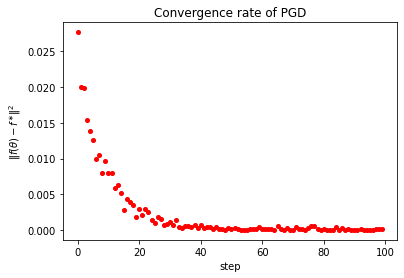

In [17]:
plt.plot(objectives, "--or", markersize=4)
plt.title("Convergence rate of PGD")
plt.xlabel("step")
plt.ylabel(r"$\Vert f(\theta) - f^{\ast}\Vert ^2$")